Import Dependencies

In [7]:
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages import convert_to_openai_messages, convert_to_messages

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import random
import ast
import inspect
import instructor
import json

#from utils.utils import get_tool_description, format_ai_message





<h4>Single Node Graph</h4>

In [14]:
class State(BaseModel):
    message:str
    answer: str = ""
    vibe: str

In [15]:
def append_vibes_to_query(state: State) -> dict:

    return {
        "answer": f"{state.message} {state.vibe}"
    }


In [16]:
workflow = StateGraph(State)

workflow.add_node("append_vibes_to_query", append_vibes_to_query)

workflow.add_edge(START, "append_vibes_to_query")
workflow.add_edge("append_vibes_to_query", END)

graph = workflow.compile()

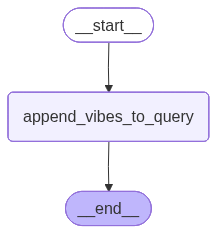

In [17]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
initial_state = {
    "message": "give me some vibes",
    "vibe": "I'm feeling like a badass today!"
}

In [19]:
result = graph.invoke(initial_state)

In [20]:
result

{'message': 'give me some vibes',
 'answer': "give me some vibes I'm feeling like a badass today!",
 'vibe': "I'm feeling like a badass today!"}

In [21]:
initial_state = {
    "message": "give me some vibes",
    "answer": "abs",
    "vibe": "I'm feeling like a badass today!"
}

In [22]:
result = graph.invoke(initial_state)

In [23]:
result

{'message': 'give me some vibes',
 'answer': "give me some vibes I'm feeling like a badass today!",
 'vibe': "I'm feeling like a badass today!"}

<h4> Conditional Graph </h4>

In [30]:
class State(BaseModel):
    message: str
    answer: str = ""

In [40]:
def append_vibes_to_query(state: State) -> dict:

    return {
        "answer": state.message
    }

In [41]:
def router(state:State)->Literal["append_vibe_1", "append_vibe_2", "append_vibe3"]:

    vibes = ["append_vibe_1", "append_vibe_2", "append_vibe3"]

    vibe_path = random.choice(vibes)
    return vibe_path


In [42]:
def append_vibe_1(state:State) -> dict:
    vibe = "I'm feeling like a badass today!"

    return {
        "answer": f"{state.answer} {vibe}"
    }

def append_vibe_2(state:State) -> dict:
    vibe = "I'm feeling like a boss today!"

    return {
        "answer": f"{state.answer} {vibe}"
    }

def append_vibe_3(state:State) -> dict:
    vibe = "I'm feeling like a legend today!"

    return {
        "answer": f"{state.answer} {vibe}"
    }



In [43]:
workflow = StateGraph(State)

workflow.add_node("append_vibes_to_query", append_vibes_to_query)
workflow.add_node("append_vibe_1", append_vibe_1)
workflow.add_node("append_vibe_2", append_vibe_2)
workflow.add_node("append_vibe_3", append_vibe_3)

workflow.add_conditional_edges(
    "append_vibes_to_query",
    router, 
    {
        "append_vibe_1": "append_vibe_1",
        "append_vibe_2": "append_vibe_2",
        "append_vibe_3": "append_vibe_3",
    }
    
)

workflow.add_edge(START, "append_vibes_to_query")
workflow.add_edge("append_vibe_1", END)
workflow.add_edge("append_vibe_2", END)
workflow.add_edge("append_vibe_3", END)


graph = workflow.compile()

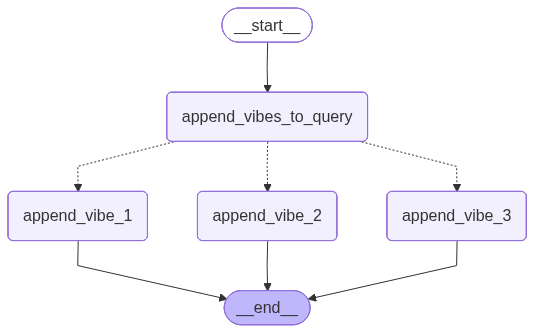

In [44]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
initial_state = {
    "message": "I am here to add  some vibes",
}

In [48]:
result = graph.invoke(initial_state)

In [49]:
result

{'message': 'I am here to add  some vibes',
 'answer': "I am here to add  some vibes I'm feeling like a boss today!"}

In [52]:
result = graph.invoke(initial_state)

In [53]:
result

{'message': 'I am here to add  some vibes',
 'answer': "I am here to add  some vibes I'm feeling like a badass today!"}